# 3 概率密度函数的估计

## 3.1 参数估计

**生成数据，并绘图**

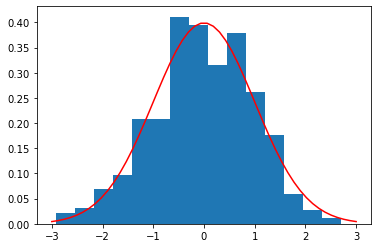

In [10]:
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np

# 以标准正态分布为例，虽然书上给的是解析法，但是为了保证一定的普适性，还是用数值优化的方法求解
x_norm = norm.rvs(size=500)  # 生成测试数据
plt.hist(x_norm, density=True, bins=15)  #归一化直方图（用出现频率代替次数），将划分区间变为 20（默认 10）
x = np.linspace(-3, 3, 50)  #在在(-3,3)之间返回均匀间隔的50个数字。
plt.plot(x, norm.pdf(x), 'r-')

### 3.1.1 最大似然法

In [2]:
from my_learning_class import PDFEstimation
from numpy import sqrt, pi, exp, log, inf

x_mean, x_std = norm.fit(x_norm)  # 解析法求参数
fun = lambda x, data: 1 / (sqrt(2 * pi) * x[1]) * exp(-0.5 * ((data - x[0]) / x[1]) ** 2)
bnds = ((-inf, inf), (0 + 1e-7, inf))  # 参数范围

instance = PDFEstimation.ParmEstimation(fun=fun, data=x_norm, bnds=bnds)
success, x = instance.mle()
assert success == True
print('由MLE算法，均值为：', x[0], '；方差为：', x[1])
print('由解析法，均值为：', x_mean, '；方差为：', x_std)

由MLE算法，均值为： -0.03456443140731087 ；方差为： 0.9811379186157199
由解析法，均值为： -0.03456327929486912 ；方差为： 0.9811395593005583


## 3.2 非参数估计

In [1]:
from my_learning_class import PDFEstimation
from numpy import sqrt, pi, exp, log, inf
import matplotlib.pyplot as plt

**生成数据，采用的分布函数为: $ (sin x + 1)/2$，其中$x\in(-\pi/2, \pi/2) $**

In [2]:
# -pi/2~pi/2范围内的（sin x+1）/2是分布函数，且采用不均匀采样（x=0附近，采样点更密）
# 将原来一个区间划为三个区间：-pi/2~-pi/20~pi/20~pi/2，样本点数均为N/3个，且均为随机采样
# 这样即使不均匀采样，又是随机采样
def generate_data(N):
    k = lambda p1, p2: p2 - p1
    b = lambda p1, p2: p1
    # x1,x2,x3是三组不同密度的数组（样本点数目均为N/3，区间长度不一样）
    x1 = k(-pi / 2, -pi / 20) * np.random.rand(int(N / 3)) + b(-pi / 2, -pi / 20)
    x2 = k(-pi / 20, pi / 20) * np.random.rand(int(N / 3)) + b(-pi / 20, pi / 20)
    x3 = k(pi / 20, pi / 2) * np.random.rand(N - 2 * int(N / 3)) + b(pi / 20, pi / 2)
    x = np.sort(np.concatenate((x1, x2, x3)))
    y = (np.sin(x) + 1) / 2
    pdf_y = np.cos(x) / 2
    return x, y, pdf_y


# 均匀样本采样
def generate_data2(N):
    x = np.linspace(-pi / 2, pi / 2, N)
    y = (np.sin(x) + 1) / 2
    pdf_y = np.cos(x) / 2
    return x, y, pdf_y


# -pi/2~pi/2区间内随机产生两个点，再划分为三个区间，中间区间的密度要大于两边区间的密度
# 就是相对于generate_data方法，高密度区域不再以0为中心且固定
def generate_data3(N):
    k = lambda p1, p2: p2 - p1
    b = lambda p1, p2: p1
    # 四个点，将区间分为三段
    p1, p4 = -pi / 2, pi / 2
    while 1:
        p2, p3 = pi * np.sort(np.random.rand(2)) - pi / 2
        if pi / 10 > p3 - p2 > pi / 30:
            break
    x1 = k(p1, p2) * np.random.rand(int(N / 3)) + b(p1, p2)
    x2 = k(p2, p3) * np.random.rand(int(N / 3)) + b(p2, p3)
    x3 = k(p3, p4) * np.random.rand(N - 2 * int(N / 3)) + b(p3, p4)
    x = np.sort(np.concatenate((x1, x2, x3)))
    y = (np.sin(x) + 1) / 2
    pdf_y = np.cos(x) / 2
    return x, y, pdf_y

**画出采样点的散点图，可以看出采样不均匀且随机**

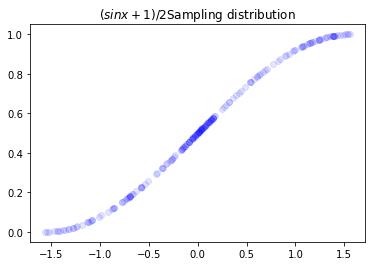

In [4]:
N = 200
x, y, pdf_y = generate_data(N)
plt.figure()
plt.plot(x, y, 'bo', alpha=0.1)
plt.title('$(sinx+1)/2$Sampling distribution')
plt.show()

### 3.2.1 直方图法

**不均匀样本绘图**

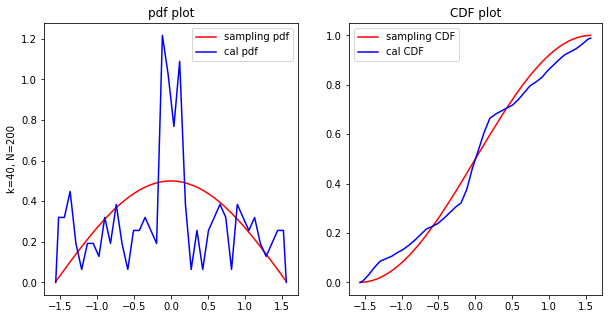

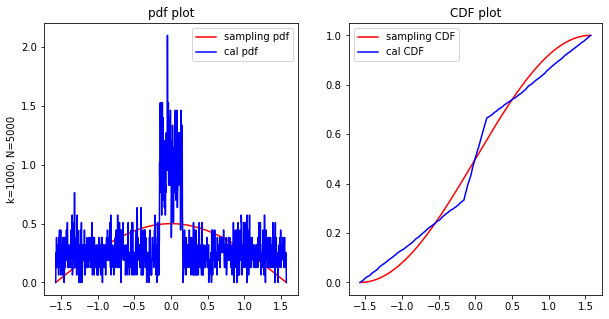

In [8]:
Ns = [200, 5000]  # 样本总数
k_ratios = [0.2]  # k=k_ratio * N
for N in Ns:
    x, y, pdf_y = generate_data(N)
    instance = PDFEstimation.NonParmEstimation(x=x, y=y, pdf_y=pdf_y)
    for k_ratio in k_ratios:
        instance.hist(int(N * k_ratio))
        instance.plot()

CDF图像变成了三段折线，这可能和采样方式有关

**均匀样本绘图**

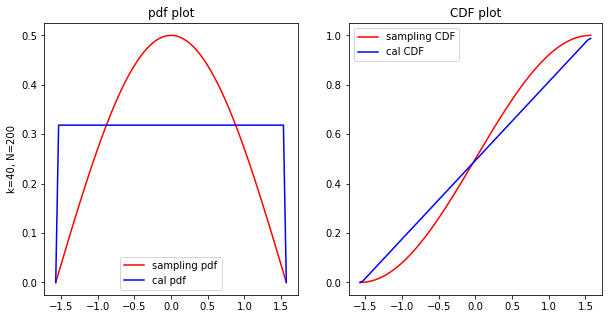

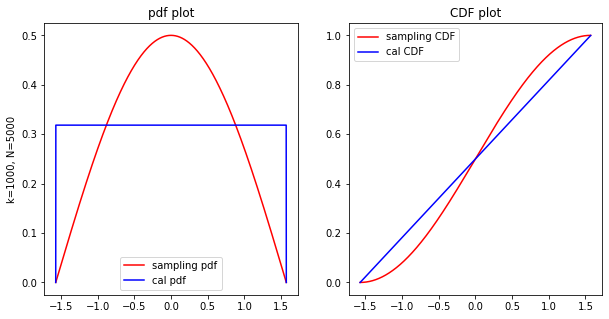

In [11]:
Ns = [200, 5000]  # 样本总数
k_ratios = [0.2]  # k=k_ratio * N
for N in Ns:
    x, y, pdf_y = generate_data2(N)
    instance = PDFEstimation.NonParmEstimation(x=x, y=y, pdf_y=pdf_y)
    for k_ratio in k_ratios:
        instance.hist(int(N * k_ratio))
        instance.plot()

可以看出来这个这个pdf和cdf极度不正常，直方图法确实还和采样方式有关，毕竟哪个地方采样的多，那么它的密度就大，相应的pdf图像上就会有凸起

**随机局部高密度**

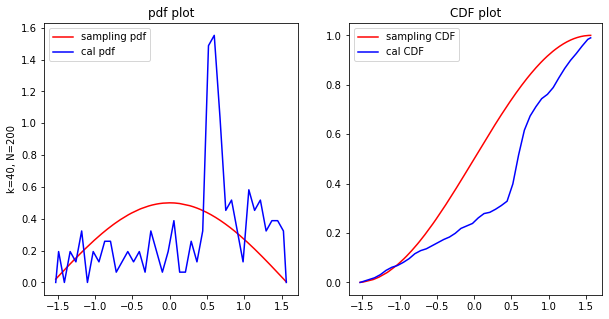

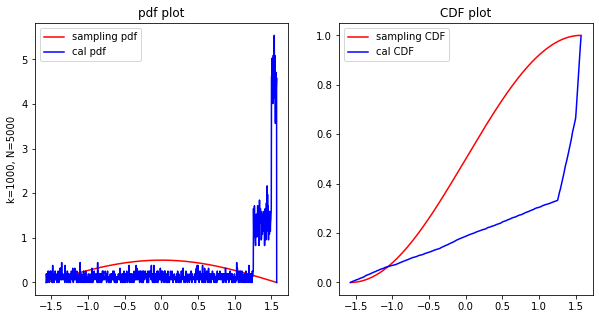

In [5]:
Ns = [200, 5000]  # 样本总数
k_ratios = [0.2]  # k=k_ratio * N
for N in Ns:
    x, y, pdf_y = generate_data3(N)
    instance = PDFEstimation.NonParmEstimation(x=x, y=y, pdf_y=pdf_y)
    for k_ratio in k_ratios:
        instance.hist(int(N * k_ratio))
        instance.plot()

可以看出来，确实是哪里样本点多，哪里pdf大，但采样是采样，函数是函数，这个特性并不合理

### 3.2.2 kn近邻算法

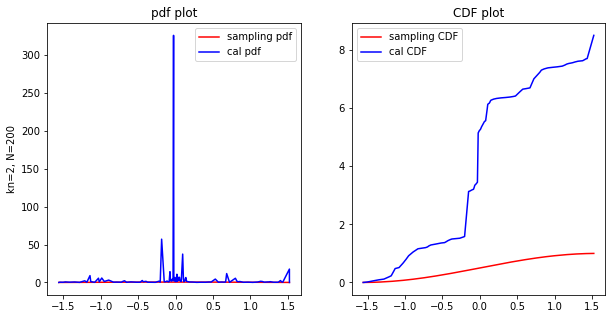

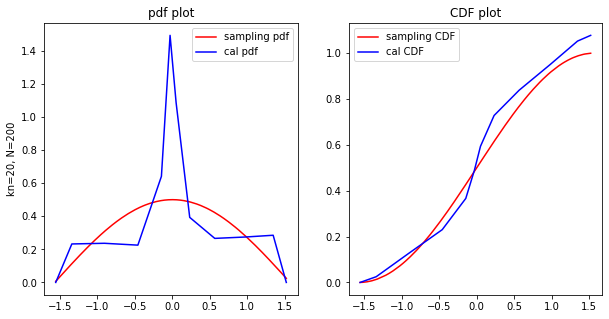

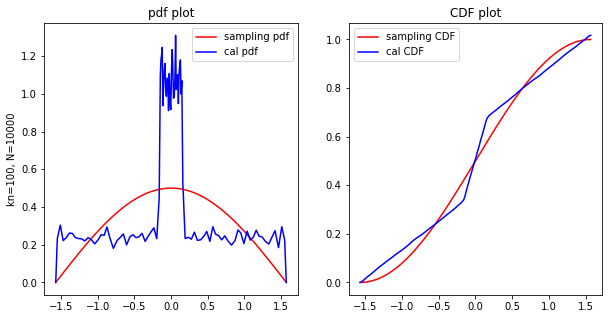

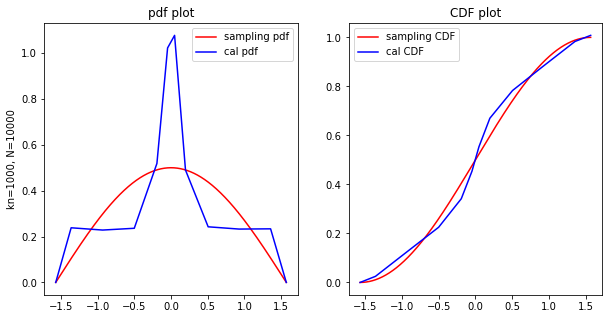

In [3]:
Ns = [200, 10000]  # 样本总数
kn_ratios = [0.01, 0.1]  # kn=kn_ratio * N
for N in Ns:
    x, y, pdf_y = generate_data(N)
    instance = PDFEstimation.NonParmEstimation(x=x, y=y, pdf_y=pdf_y)
    for kn_ratio in kn_ratios:
        instance.kn_neighbor(int(N * kn_ratio))
        instance.plot()

可以看出来，kn算法对那三个条件要求较高，如果不满足，别说分布函数是否一致了，连积分是否为1都保证不了

### 3.2.3 Parzen窗法

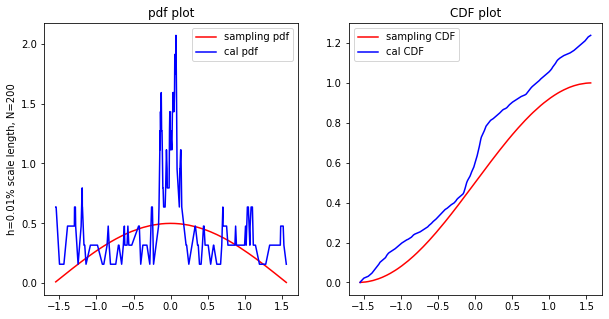

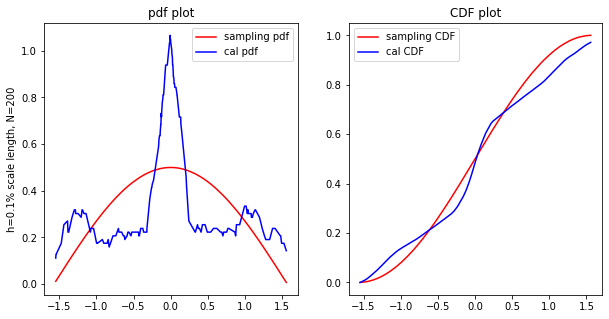

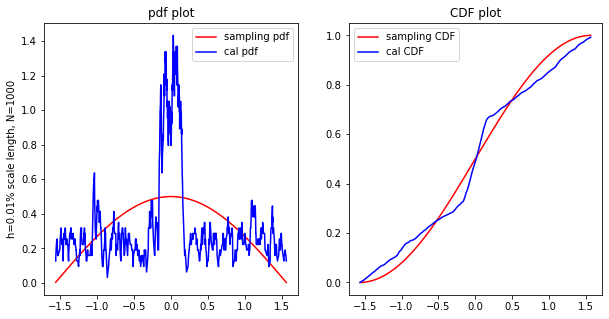

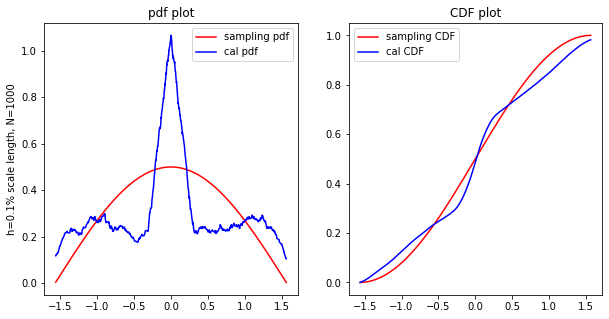

In [3]:
Ns = [200, 1000]  # 样本总数
hn_ratios = [0.01, 0.1]  # hn=hn_ratio * pi，（pi为区间长度）
for N in Ns:
    x, y, pdf_y = generate_data(N)
    instance = PDFEstimation.NonParmEstimation(x=x, y=y, pdf_y=pdf_y)
    for hn_ratio in hn_ratios:
        instance.parzen(pi * hn_ratio)
        instance.plot()

# 4 隐马尔科夫模型与贝叶斯网络

## 4.3 HMM

### 4.3.1 模型评估

**记号与例子来自李航统计学习方法，第二版，第十章**

In [2]:
import my_learning_class as mlc
import numpy as np

In [4]:
A = np.array([[0.5, 0.2, 0.3], [0.3, 0.5, 0.2], [0.2, 0.3, 0.5]])
E = np.array([[0.5, 0.5], [0.4, 0.6], [0.7, 0.3]])
Pi = np.array([0.2, 0.4, 0.4])
O = np.array([0, 1, 0])
Q = np.array([1, 2, 3])
V = np.array([1, 2])

instance = mlc.HMM(A=A, E=E, Pi=Pi, O=O, Q=Q, V=V)

**前向算法**

In [5]:
instance.forward()

(0.130218,
 array([[0.1     , 0.16    , 0.28    ],
        [0.077   , 0.1104  , 0.0606  ],
        [0.04187 , 0.035512, 0.052836]]))

**后向算法**

In [6]:
instance.backward()

(0.130218,
 array([[0.2451, 0.2622, 0.2277],
        [0.54  , 0.49  , 0.57  ],
        [1.    , 1.    , 1.    ]]))

### 4.3.2 推断问题

In [7]:
instance.viterbi()

(0.014699999999999998, array([2., 2., 2.]))

### 4.3.3 HMM学习问题

**真实模型参数**

In [13]:
A = np.array([[0, 1, 0], [0.1, 0, 0.9], [0.2, 0.8, 0]])
E = np.array([[0.9, 0.1], [1, 0], [0.15, 0.85]])
Pi = np.array([0, 1, 0])
Q = np.array([0, 1, 2], dtype=np.int32)
V = np.array([0, 1], dtype=np.int32)
n = 100
iter_times = 200

**随机生成观测序列**

In [10]:
hmm = mlc.HMM(A=A, E=E, Pi=Pi, Q=Q, V=V)
hmm.create_random_O(n)

**随机初始化初始模型参数**

In [11]:
np.random.seed(29)

A2 = A + 0.2 * np.random.rand(3, 3)
E2 = E + 0.2 * np.random.rand(3, 2)
for i in range(3):
    A2[i, :] /= sum(A2[i, :])
    E2[i, :] /= sum(E2[i, :])
Pi2 = Pi + 0.2 * np.random.rand(3)
Pi2 = Pi2/sum(Pi2)

hmm2 = mlc.HMM(A=A2, E=E2, Pi=Pi2, Q=Q, V=V, O=hmm.O)

**知道隐状态**

In [12]:
A_hat, E_hat = hmm2.know_x(hmm.x)
print(f'A-A_hat: \n {A-A_hat}')
print(f'E-E_hat: \n {E-E_hat}')

A-A_hat: 
 [[ 0.          0.          0.        ]
 [-0.07021277  0.          0.07021277]
 [ 0.04210526 -0.04210526  0.        ]]
E-E_hat: 
 [[ 0.04285714 -0.04285714]
 [ 0.          0.        ]
 [ 0.0474359  -0.0474359 ]]


**不知道隐状态**

In [14]:
for i in range(iter_times):
    _, predicted_x = hmm2.viterbi()  # 获得当前模型参数下的最可能隐状态
    hmm2.x = predicted_x

    p_t_ij, p_t_j = hmm2.E_step()
    A_hat, E_hat, Pi_hat = hmm2.M_step(p_t_ij, p_t_j)

    hmm2.A = A_hat
    hmm2.E = E_hat
    hmm2.Pi = Pi_hat


In [15]:
print(f'A-A_hat: \n {A-A_hat}')
print(f'E-E_hat: \n {E-E_hat}')
print(f'Pi-Pi_hat: \n {E-E_hat}')

A-A_hat: 
 [[-2.05813231e-01  2.05868149e-01 -5.49186483e-05]
 [-9.28153963e-02 -2.39724225e-04  9.30551206e-02]
 [ 8.89343327e-02 -6.05020406e-02 -2.84322920e-02]]
E-E_hat: 
 [[-9.96738031e-002  9.96738031e-002]
 [ 0.00000000e+000 -2.35312929e-176]
 [ 1.24293059e-001 -1.24293059e-001]]
Pi-Pi_hat: 
 [[-9.96738031e-002  9.96738031e-002]
 [ 0.00000000e+000 -2.35312929e-176]
 [ 1.24293059e-001 -1.24293059e-001]]


# 5 线性学习机器与线性分类器

In [12]:
import my_learning_class as mlc
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

**线性可分数据集**

In [3]:
n_samples = 100
seed = 42
centers = [[1, 1], [-1, -1]]
std = 0.5
prior = np.array([0.5, 0.5])
data, label = datasets.make_blobs(n_samples=n_samples, n_features=2, centers=centers, cluster_std=std,
                                  random_state=seed)
instance = mlc.LinearClassifier(data, label, prior)

## 5.1 Fisher

**线性可分数据集**

In [6]:
def my_plot(data, label, fisher_decision):
    left_right = np.array([1.1 * min(data[:, 0]), 1.1 * max(data[:, 0])])
    data0 = data[np.where(label == -1)[0]]
    data1 = data[np.where(label == 1)[0]]

    plt.figure()
    plt.plot(data0[:, 0], data0[:, 1],  'o', label='class -1')
    plt.plot(data1[:, 0], data1[:, 1], 'o', label='class 1')
    plt.plot(left_right, fisher_decision(left_right), label='decision curve')

    plt.legend()

    plt.show()

In [9]:
n_samples = 500
seed = 42
centers = [[1, 1], [-1, -1]]
std = 0.4
prior = np.array([0.5, 0.5])
data, label = datasets.make_blobs(n_samples=n_samples, n_features=2, centers=centers, cluster_std=std)
label = 2 * label - 1

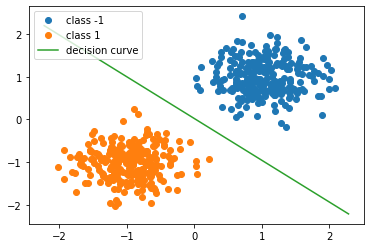

In [10]:
fisher_instance = mlc.LinearClassifier(data, label, prior)
omega, mean0, mean1 = fisher_instance.fisher_fit()
fisher_decision = lambda x: (np.log(prior[1] / prior[0]) + (omega[1] * (mean0[1] + mean1[1])) / 2 - omega[0] * (x - (mean0[0] + mean1[0]) / 2)) / omega[1]
my_plot(data, label, fisher_decision)

In [13]:
print(f'准确率为：{accuracy_score(label[:, np.newaxis], fisher_instance.predict(data))}')

准确率为：1.0


可以看出，对于线性可分的数据集，Fisher变换可以使得经验误差为0

**线性不可分数据集**

In [14]:
n_samples = 500
seed = 42
centers = [[1, 1], [-1, -1]]
std = 1.2
prior = np.array([0.5, 0.5])
data, label = datasets.make_blobs(n_samples=n_samples, n_features=2, centers=centers, cluster_std=std)
label = 2 * label - 1

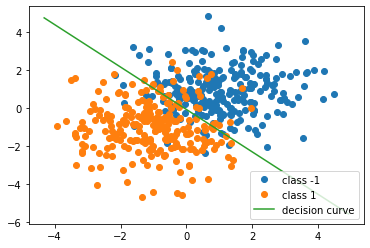

In [15]:
fisher_instance = mlc.LinearClassifier(data, label, prior)
omega, mean0, mean1 = fisher_instance.fisher_fit()
fisher_decision = lambda x: (np.log(prior[1] / prior[0]) + (omega[1] * (mean0[1] + mean1[1])) / 2 - omega[0] * (x - (mean0[0] + mean1[0]) / 2)) / omega[1]
my_plot(data, label, fisher_decision)

In [16]:
print(f'准确率为：{accuracy_score(label[:, np.newaxis], fisher_instance.predict(data))}')

准确率为：0.898


## 5.8 线性支持向量机

### 5.8.1 线性可分

In [5]:
import matplotlib.pyplot as plt
import my_learning_class as mlc
import numpy as np

In [6]:
def my_plot(title=None):
    plt.Figure()
    plt.plot(data[np.where(label == -1), 0].T, data[np.where(label == -1), 1].T, 'ro', label='class -1')
    plt.plot(data[np.where(label == 1), 0].T, data[np.where(label == 1), 1].T, 'b^', label='class 1')
    plt.plot(np.array([left, right]), linear_fun(np.array([left, right])), label='decision line')
    plt.plot(np.array([left, right]), boundary1_fun(np.array([left, right])), 'g--', label='boundaries line')
    plt.plot(np.array([left, right]), boundary2_fun(np.array([left, right])), 'g--')

    # temp = [str(i + 1) for i in range(data.shape[0])]
    # for i in range(data.shape[0]):
    #     plt.text(data[i, 0] + 0.1, data[i, 1] + 0.1, temp[i], fontsize=15)

    plt.xlim(left, right)
    plt.ylim(bottom, top)
    plt.legend()
    plt.title(title)
    plt.show()

In [7]:
data = np.array([[0, 0], [1, 1], [1, 2], [2, 1], [4, 1], [4, 2], [2, 3], [3, 2]])
left, right = -1, 5
bottom, top = -1, 5
label = np.array([-1, -1, -1, -1, 1, 1, 1, 1])
omega, b = None, None
linear_fun = lambda x0: (-b - x0 * omega[0]) / omega[1]
boundary1_fun = lambda x0: (-b - x0 * omega[0] + 1) / omega[1]
boundary2_fun = lambda x0: (-b - x0 * omega[0] - 1) / omega[1]

E:\AAAMySoftWares\Anaconda3\lib\site-packages\scipy\optimize\_differentialevolution.py:898: UserWarning: differential evolution didn't find a solution satisfying the constraints, attempting to polish from the least infeasible solution
  warnings.warn("differential evolution didn't find a"
E:\AAAMySoftWares\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


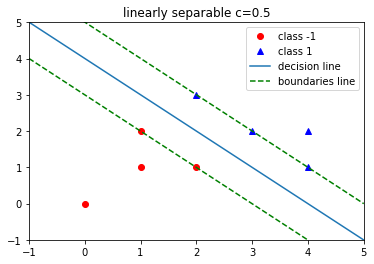

E:\AAAMySoftWares\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


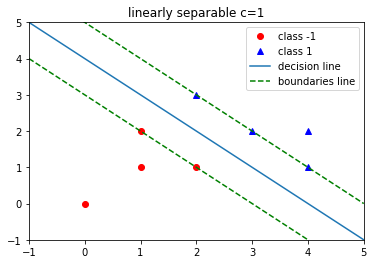

E:\AAAMySoftWares\Anaconda3\lib\site-packages\scipy\optimize\_differentialevolution.py:898: UserWarning: differential evolution didn't find a solution satisfying the constraints, attempting to polish from the least infeasible solution
  warnings.warn("differential evolution didn't find a"
E:\AAAMySoftWares\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


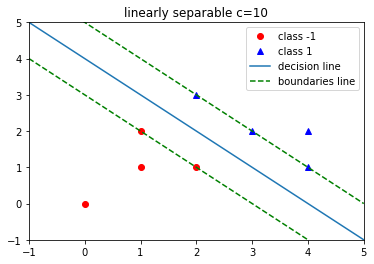

E:\AAAMySoftWares\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


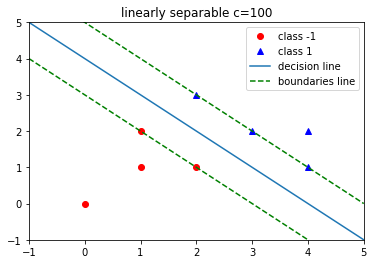

In [8]:
for c in [0.5,1,10,100]:
    instance = mlc.LinearClassifier(data, label)
    omega, b = instance.linear_svm(c=c)
    my_plot('linearly separable c='+str(c))

**可以看对于线性可分数据集，c的大小并不影响最终结果（不影响决策平面与边界平面的斜率、截距），对于线性可分数据集是没有c的，或者认为c为+∞**

### 5.8.3 线性不可分

In [10]:
data = np.array([[3, 4], [0, 0], [1, 1], [1, 2], [3, 1], [4, 1], [4, 2], [2, 3], [3.5, 2], [1.5, 0], [0,3], [4,0]])
label = np.array([-1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, -1])

E:\AAAMySoftWares\Anaconda3\lib\site-packages\scipy\optimize\_differentialevolution.py:898: UserWarning: differential evolution didn't find a solution satisfying the constraints, attempting to polish from the least infeasible solution
  warnings.warn("differential evolution didn't find a"
E:\AAAMySoftWares\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


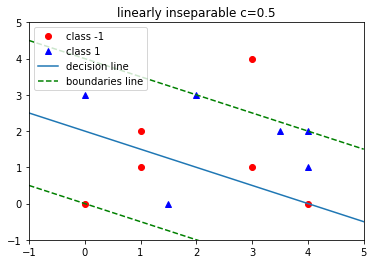

E:\AAAMySoftWares\Anaconda3\lib\site-packages\scipy\optimize\_differentialevolution.py:898: UserWarning: differential evolution didn't find a solution satisfying the constraints, attempting to polish from the least infeasible solution
  warnings.warn("differential evolution didn't find a"
E:\AAAMySoftWares\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


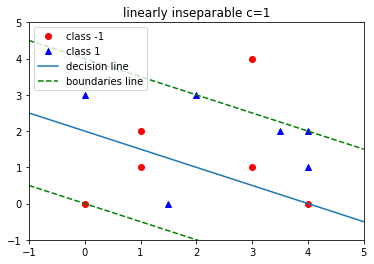

E:\AAAMySoftWares\Anaconda3\lib\site-packages\scipy\optimize\_differentialevolution.py:898: UserWarning: differential evolution didn't find a solution satisfying the constraints, attempting to polish from the least infeasible solution
  warnings.warn("differential evolution didn't find a"


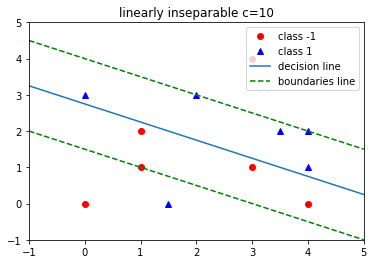

E:\AAAMySoftWares\Anaconda3\lib\site-packages\scipy\optimize\_differentialevolution.py:898: UserWarning: differential evolution didn't find a solution satisfying the constraints, attempting to polish from the least infeasible solution
  warnings.warn("differential evolution didn't find a"
E:\AAAMySoftWares\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


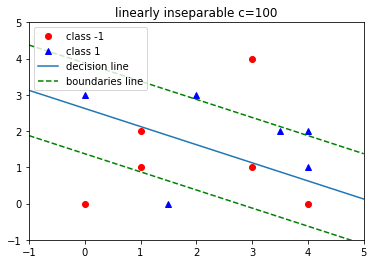

In [11]:
for i ,c in enumerate([0.5,1,10,100]):
    instance = mlc.LinearClassifier(data, label)
    omega, b = instance.linear_svm(c=c)
    my_plot('linearly inseparable c='+str(c))

**对于线性不可分数据，可以看出当C变化的确会影响错分样本数目（c=0.5错分三个，c=100错分1个）**

# 6典型非线性分类器（BP）

In [ ]:
import numpy as np
from sklearn.metrics import  accuracy_score
import matplotlib.pyplot as plt
import my_learning_class as mlc
np.random.seed(49)

In [2]:
def my_plot(decision_curve, data, left, right, bottom, top, mlc_nn):
    plt.figure()
    plt.plot(decision_curve[:, 0], decision_curve[:, 1])

    plt.plot(data[:4, 0], data[:4, 1], 'o')
    plt.plot(data[4:, 0], data[4:, 1], '^')
    plt.xlim(left, right)
    plt.ylim(bottom, top)
    plt.show()

    plt.figure()
    plt.plot(np.arange(start=1, stop=1 + len(mlc_nn.loss)), mlc_nn.loss)
    plt.show()

In [3]:
data = np.array([[0, 0], [1, 1], [1, 2], [2, 1], [3, 2], [4, 1], [4, 2], [4, 3], [5, 2]])
label = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1])
left, right = -1, 6
bottom, top = -1, 4

In [4]:
mlc_nn = mlc.NN([2, 3, 1])
mlc_nn.backward(data, label)

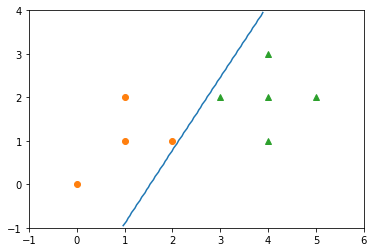

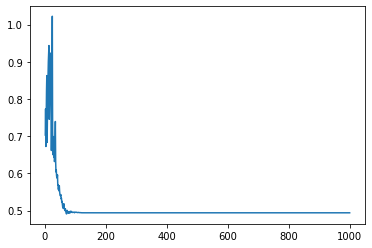

正确率为： 1.0


In [5]:
decision_curve = mlc.Utils().cal_decision_curve(left, right, bottom, top, predict_fun=mlc_nn.predict)
my_plot(decision_curve, data, left, right, bottom, top, mlc_nn)
print('正确率为：', accuracy_score(mlc_nn.predict(data), label))

**第一张图了两类的散点图与决策面；第二张图绘制了训练过程中的交叉熵损失，为了省事，这里并没有与损失相关的停止策略，而是固定训练1000次才停止，所以这里有一个长尾；最后给出了分类的正确率**
**不过神经网络对初值和学习率都很敏感，换个初值可能准确率就暴跌了**

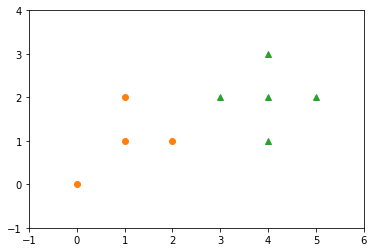

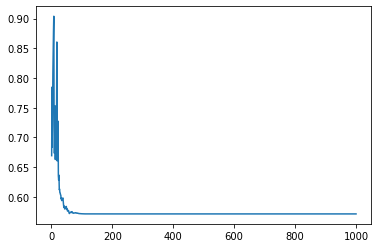

预测输出类别为：： [0 0 0 0 0 0 0 0 0]
正确率为： 0.4444444444444444


In [7]:
np.random.seed(40)
mlc_nn = mlc.NN([2, 3, 1])
mlc_nn.backward(data, label)
decision_curve = mlc.Utils().cal_decision_curve(left, right, bottom, top, predict_fun=mlc_nn.predict)
my_plot(decision_curve, data, left, right, bottom, top, mlc_nn)
print('预测输出类别为：：', mlc_nn.predict(data))
print('正确率为：', accuracy_score(mlc_nn.predict(data), label))

**像这个是压根没分出来，第一张内全都分为了一个类别（0类），且由于本身就有4个0类，所以正确率还是有44%**

## 6.5 支持向量机

### 6.5.2 核函数变换与支持向量机

In [1]:
import matplotlib.pyplot as plt
import my_learning_class as mlc
import numpy as np
np.random.rand(43)

array([0.44297901, 0.39484981, 0.38959337, 0.01826066, 0.49268724,
       0.72851762, 0.41769064, 0.95744102, 0.20810256, 0.47947664,
       0.21858276, 0.97278178, 0.77704053, 0.47164909, 0.43830421,
       0.13572671, 0.50849657, 0.12265112, 0.70202726, 0.47037048,
       0.28276448, 0.2076062 , 0.25499374, 0.55643639, 0.59337914,
       0.68303934, 0.38224995, 0.44055118, 0.56007051, 0.24481142,
       0.0015189 , 0.12361701, 0.50835652, 0.99499203, 0.5305722 ,
       0.76952736, 0.49672826, 0.6068236 , 0.49638361, 0.34623089,
       0.67082536, 0.72091804, 0.20780043])

In [2]:
def my_plot(title=None):
    plt.Figure()

    # plt.plot(grid[np.where(grid_label == -1)[0]][:, 0], grid[np.where(grid_label == -1)[0]][:, 1],
    #          color='orange', marker='o', label='area -1', alpha=0.2)
    # plt.plot(grid[np.where(grid_label == 1)[0]][:, 0], grid[np.where(grid_label == 1)[0]][:, 1],
    #          color='cyan', marker='o', label='area 1', alpha=0.2)

    plt.plot(grid[:, 0], grid[:, 1], 'x', color='cornflowerblue', label='decision curve', markersize=2)
    plt.plot(grid2[:, 0], grid2[:, 1], 'go', label='boundaries curve', markersize=2)
    plt.plot(grid3[:, 0], grid3[:, 1], 'go', markersize=2)

    plt.plot(data[np.where(label == -1), 0].T, data[np.where(label == -1), 1].T, 'ro', label='class -1')
    plt.plot(data[np.where(label == 1), 0].T, data[np.where(label == 1), 1].T, 'b^', label='class 1')

    temp = [str(i + 1) for i in range(data.shape[0])]
    for i in range(data.shape[0]):
        plt.text(data[i, 0] + 0.1, data[i, 1] + 0.1, temp[i], fontsize=15)

    plt.xlim(left, right)
    plt.ylim(bottom, top)
    plt.legend(loc='lower right')
    plt.title(title)
    plt.show()

In [3]:
data = np.array(
    [[-3, -1], [-3, 0], [-1, 3], [0, 3], [2, 2], [3, 0], [-1, 0], [0, 0], [1, 0], [0, -1], [1, -1], [1, 3], [0, -3]])
label = np.array([-1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, -1])
label[np.where(label == 0)] = -1

left, right = -4, 6
bottom, top = -6, 4

instance = mlc.LinearClassifier(data, label)

E:\AAAMySoftWares\Anaconda3\lib\site-packages\scipy\optimize\_differentialevolution.py:898: UserWarning: differential evolution didn't find a solution satisfying the constraints, attempting to polish from the least infeasible solution
  warnings.warn("differential evolution didn't find a"
E:\AAAMySoftWares\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


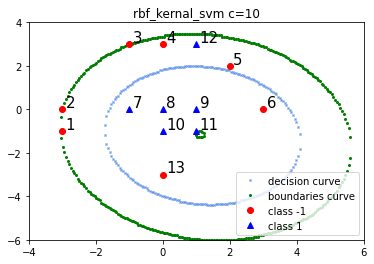

E:\AAAMySoftWares\Anaconda3\lib\site-packages\scipy\optimize\_differentialevolution.py:898: UserWarning: differential evolution didn't find a solution satisfying the constraints, attempting to polish from the least infeasible solution
  warnings.warn("differential evolution didn't find a"
E:\AAAMySoftWares\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


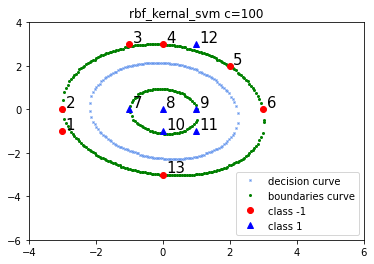

E:\AAAMySoftWares\Anaconda3\lib\site-packages\scipy\optimize\_differentialevolution.py:898: UserWarning: differential evolution didn't find a solution satisfying the constraints, attempting to polish from the least infeasible solution
  warnings.warn("differential evolution didn't find a"
E:\AAAMySoftWares\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


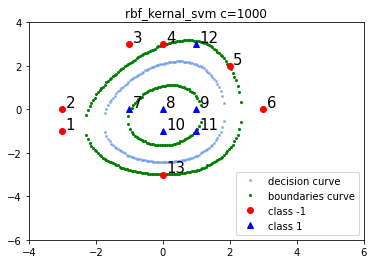

E:\AAAMySoftWares\Anaconda3\lib\site-packages\scipy\optimize\_differentialevolution.py:898: UserWarning: differential evolution didn't find a solution satisfying the constraints, attempting to polish from the least infeasible solution
  warnings.warn("differential evolution didn't find a"
E:\AAAMySoftWares\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


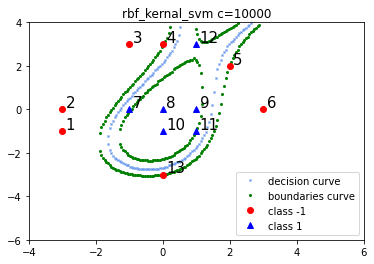

In [4]:
for i, c in enumerate([10, 100, 1000,10000]):
    instance = mlc.LinearClassifier(data, label)
    instance.kernal_svm(c=c)
    grid = mlc.Utils().cal_decision_curve(left, right, bottom, top, instance.predict)
    grid2 = mlc.Utils().cal_decision_curve(left, right, bottom, top, instance.boundary_func, step=200)
    grid3 = mlc.Utils().cal_decision_curve(left, right, bottom, top, instance.boundary_func2, step=200)
    my_plot('rbf_kernal_svm c=' + str(c))

**由核支持向量机可以更加明显的看出参数C的作用（C越大，对错误样本的惩罚越高，决策面越奇怪）：**
**可以看出C=10000时，错分点数为0，但是决策面也变得更不规则**

### 6.5.6 用于函数拟合的支持向量机-支持向量回归

In [6]:
import my_learning_class as mlc
import numpy as np
import matplotlib.pyplot as plt

In [7]:
def my_plot(x, y, omega, b, eps):
    plt.figure()
    plt.plot(x, y,  'go', markersize=4)
    temp = [str(i + 1) for i in range(x.shape[0])]
    for i in range(x.shape[0]):
        plt.text(x[i] + 0.1, y[i] + 1, temp[i], fontsize=15)

    y_hat = omega * x + b
    plt.plot(x, y_hat, 'r', label='fitting curve')

    y_hat_eps = omega * x + b + eps
    plt.plot(x, y_hat_eps, 'b--', label='eps-channel 1')

    y_hat_eps_2 = omega * x + b - eps
    plt.plot(x, y_hat_eps_2, 'b--', label='eps-channel 2')

    plt.legend(loc='lower right')
    plt.show()

**定义真实模型**

In [8]:
np.random.seed(8)
n = 10
k = 2
b = 1
eps=1.5
c=10


f = lambda x: k * x + b
x = np.sort(10 * np.random.rand(n))
y = f(x) + 6 * np.random.rand(n)

**拟合数据**

In [9]:
instance = mlc.NonLinearClassifier(x, y, eps)
omega, b = instance.SVR(c)

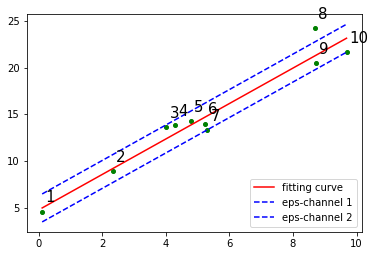

In [10]:
my_plot(x, y, omega, b, eps)

# 8 非参数学习机器与集成学习

In [2]:
import my_learning_class as mlc
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
np.random.seed(42)

**二维画图，仅适用于dim_ratio=1**

In [3]:
def my_plot(data0_train, data1_train, data2_train, data0_test, data1_test, data2_test, test_data, cal_label,
            test_label):
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    # 原始图像，train为已知数据集（圆形），test为预测数据集（叉号）
    plt.plot(data0_train[:, 0], data0_train[:, 1], 'ro', label='class 0 train', alpha=0.3)
    plt.plot(data1_train[:, 0], data1_train[:, 1], 'go', label='class 1 train', alpha=0.3)
    plt.plot(data2_train[:, 0], data2_train[:, 1], 'bo', label='class 2 train', alpha=0.3)
    plt.plot(data0_test[:, 0], data0_test[:, 1], 'rx', label='class 0 test')
    plt.plot(data1_test[:, 0], data1_test[:, 1], 'gx', label='class 1 test')
    plt.plot(data2_test[:, 0], data2_test[:, 1], 'bx', label='class 2 test')
    plt.legend()
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()

    # 圆形透明为训练样本，叉号透明为正确分类的测试样本，叉号实心为错误分类的测试样本（颜色代表被错分为哪一类）
    plt.subplot(1, 2, 2)
    plt.plot(data0_train[:, 0], data0_train[:, 1], 'ro', label='class 0 train', alpha=0.3)
    plt.plot(data1_train[:, 0], data1_train[:, 1], 'go', label='class 1 train', alpha=0.3)
    plt.plot(data2_train[:, 0], data2_train[:, 1], 'bo', label='class 2 train', alpha=0.3)
    plt.plot(test_data[np.where((cal_label == 0) * (test_label == 0)), 0].T,
             test_data[np.where((cal_label == 0) * (test_label == 0)), 1].T, 'rx',
             label='class 0 cal correct', alpha=0.3)
    plt.plot(test_data[np.where((cal_label == 1) * (test_label == 1)), 0].T,
             test_data[np.where((cal_label == 1) * (test_label == 1)), 1].T, 'gx',
             label='class 1 cal correct', alpha=0.3)
    plt.plot(test_data[np.where((cal_label == 2) * (test_label == 2)), 0].T,
             test_data[np.where((cal_label == 2) * (test_label == 2)), 1].T, 'bx',
             label='class 2 cal correct', alpha=0.3)

    plt.plot(test_data[np.where((cal_label == 0) * (test_label != 0)), 0].T,
             test_data[np.where((cal_label == 0) * (test_label != 0)), 1].T, 'rx',
             label='class 0 cal wrong')
    plt.plot(test_data[np.where((cal_label == 1) * (test_label != 1)), 0].T,
             test_data[np.where((cal_label == 1) * (test_label != 1)), 1].T, 'gx',
             label='class 1 cal wrong')
    plt.plot(test_data[np.where((cal_label == 2) * (test_label != 2)), 0].T,
             test_data[np.where((cal_label == 2) * (test_label != 2)), 1].T, 'bx',
             label='class 2 cal wrong')
    plt.legend()
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.show()

**生成3类数据，数据维度为n_samples×(dim_ratio×2)**

In [4]:
def generate_3_class_data(n_samples=7500, dim_ratio=1):
    centers = [dim_ratio * [100000, 100000], dim_ratio * [-100000, -100000], dim_ratio * [-100000, 100000]]
    std = 60000
    data, label = datasets.make_blobs(n_samples=n_samples, n_features=2, centers=centers, cluster_std=std)
    data0 = data[np.where(label == 0), :][0]
    data1 = data[np.where(label == 1), :][0]
    data2 = data[np.where(label == 2), :][0]
    data0_train, data0_test = train_test_split(data0, test_size=0.5)
    data1_train, data1_test = train_test_split(data1, test_size=0.5)
    data2_train, data2_test = train_test_split(data2, test_size=0.5)
    train_data = np.concatenate((data0_train, data1_train, data2_train))
    train_label = np.concatenate(
        (0 * np.ones(data0_train.shape[0], dtype=np.int8),
         1 * np.ones(data1_train.shape[0], dtype=np.int8),
         2 * np.ones(data2_train.shape[0], dtype=np.int8))
    )
    train_shuffle = np.arange(train_data.shape[0])
    np.random.shuffle(train_shuffle)
    train_data = train_data[train_shuffle, :]
    train_label = train_label[train_shuffle]

    test_data = np.concatenate((data0_test, data1_test, data2_test))
    test_label = np.concatenate(
        (0 * np.ones(data0_test.shape[0], dtype=np.int8),
         1 * np.ones(data1_test.shape[0], dtype=np.int8),
         2 * np.ones(data2_test.shape[0], dtype=np.int8))
    )
    test_shuffle = np.arange(test_data.shape[0])
    np.random.shuffle(test_shuffle)
    test_data = test_data[train_shuffle, :]
    test_label = test_label[train_shuffle]
    return data0_train, data1_train, data2_train, data0_test, data1_test, data2_test, train_data, train_label, test_data, test_label

In [15]:
def my_evaluate(test_label, cal_label):
    Sn, Sp, Acc, Rec, Pre, F = mlc.Utils.classifier_effect(test_label, cal_label, 0)
    print(f'0为阳性：Sn为{100 * Sn:.2f}%, Sp{100 * Sp:.2f}%, Acc{100 * Acc:.2f}%, Rec{100 * Rec:.2f}%, Pre为{100 * Pre:.2f}%, F为{100 * F:.2f}%')

    Sn, Sp, Acc, Rec, Pre, F = mlc.Utils.classifier_effect(test_label, cal_label, 1)
    print(f'1为阳性：Sn为{100 * Sn:.2f}%, Sp{100 * Sp:.2f}%, Acc{100 * Acc:.2f}%, Rec{100 * Rec:.2f}%, Pre为{100 * Pre:.2f}%, F为{100 * F:.2f}%')

    Sn, Sp, Acc, Rec, Pre, F = mlc.Utils.classifier_effect(test_label, cal_label, 2)
    print(f'2为阳性：Sn为{100 * Sn:.2f}%, Sp{100 * Sp:.2f}%, Acc{100 * Acc:.2f}%, Rec{100 * Rec:.2f}%, Pre为{100 * Pre:.2f}%, F为{100 * F:.2f}%')

## 8.2.1 最近邻法

In [12]:
data0_train, data1_train, data2_train, data0_test, data1_test, data2_test, train_data, train_label, test_data, test_label = generate_3_class_data()

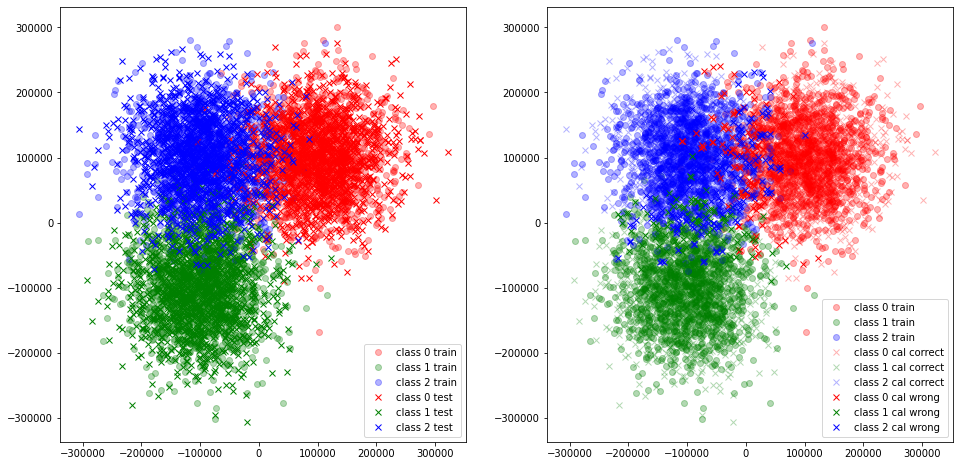

In [16]:
# method in ['nearest_neighbor', 'k_neighbor', 'clip_neighbor', 'branch_bound']
instance = mlc.NonParLearning(method='k_neighbor', data=train_data, label=train_label, c=3)  # k=1，就是最近邻
cal_label = instance.transform(x=test_data, k=1)
my_plot(data0_train, data1_train, data2_train, data0_test, data1_test, data2_test, test_data, cal_label, test_label)

**黑底图不是很好看，左图为原始图像，train为已知数据集（圆形），test为预测数据集（叉号**
**右图圆形透明为训练样本，叉号透明为正确分类的测试样本，叉号实心为错误分类的测试样本（颜色代表被错分为哪一类）**

In [17]:
my_evaluate(test_label, cal_label)

0为阳性：Sn为92.40%, Sp95.20%, Acc94.27%, Rec92.40%, Pre为90.59%, F为91.49%
1为阳性：Sn为92.96%, Sp95.92%, Acc94.93%, Rec92.96%, Pre为91.93%, F为92.44%
2为阳性：Sn为83.68%, Sp93.40%, Acc90.16%, Rec83.68%, Pre为86.37%, F为85.01%


## 8.2.2 k近邻法

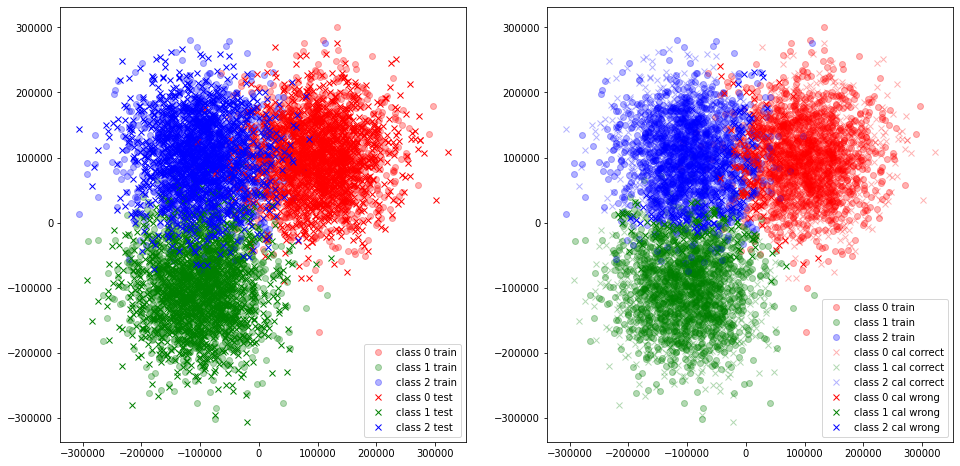

In [18]:
# method in ['nearest_neighbor', 'k_neighbor', 'clip_neighbor', 'branch_bound']
instance = mlc.NonParLearning(method='k_neighbor', data=train_data, label=train_label, c=3)
cal_label = instance.transform(x=test_data, k=5)
my_plot(data0_train, data1_train, data2_train, data0_test, data1_test, data2_test, test_data, cal_label, test_label)

In [19]:
my_evaluate(test_label, cal_label)

0为阳性：Sn为94.40%, Sp96.44%, Acc95.76%, Rec94.40%, Pre为92.99%, F为93.69%
1为阳性：Sn为94.40%, Sp96.04%, Acc95.49%, Rec94.40%, Pre为92.26%, F为93.32%
2为阳性：Sn为86.32%, Sp95.08%, Acc92.16%, Rec86.32%, Pre为89.77%, F为88.01%


## 8.2.3 kn近邻的快速算法

**这个只实现了k=1的情况**

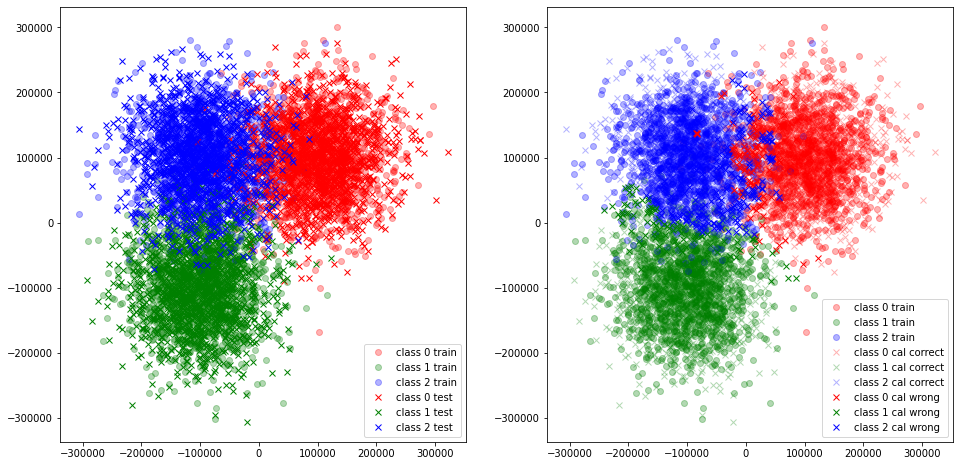

In [24]:
# method in ['nearest_neighbor', 'k_neighbor', 'clip_neighbor', 'branch_bound']
instance = mlc.NonParLearning(method='branch_bound', data=train_data, label=train_label, c=3)
cal_label = instance.transform(x=test_data)
my_plot(data0_train, data1_train, data2_train, data0_test, data1_test, data2_test, test_data, cal_label, test_label)

In [25]:
my_evaluate(test_label, cal_label)

0为阳性：Sn为92.00%, Sp96.36%, Acc94.91%, Rec92.00%, Pre为92.67%, F为92.33%
1为阳性：Sn为93.68%, Sp96.24%, Acc95.39%, Rec93.68%, Pre为92.57%, F为93.12%
2为阳性：Sn为86.56%, Sp93.52%, Acc91.20%, Rec86.56%, Pre为86.98%, F为86.77%


## 8.4 集成学习

### 8.4.1 最小平方误差判别

**算法基本思想来自5.6**

In [17]:
import matplotlib.pyplot as plt
import my_learning_class as mlc
import numpy as np
from sklearn import datasets
from sklearn.metrics import accuracy_score

In [2]:
def my_plot(data, label):
    data0 = data[np.where(label == -1)[0]]
    data1 = data[np.where(label == 1)[0]]

    plt.figure()
    plt.plot(data1[:, 0], data1[:, 1], '^', label='class 1 (w_1)')
    plt.plot(data0[:, 0], data0[:, 1],  'o', label='class -1 (w_2)')

    plt.legend()

    plt.show()

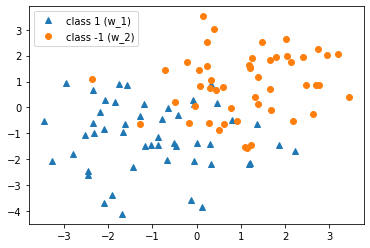

In [3]:
# 准备数据
n_samples = 100
centers = [[1, 1], [-1, -1]]
std = 1.2
prior = np.array([0.5, 0.5])
data, label = datasets.make_blobs(n_samples=n_samples, n_features=2, centers=centers, cluster_std=std)
label = 2 * label - 1

my_plot(data, label)

In [4]:
def run_lms():
    fisher_instance = mlc.Bossting(data, label, 10)
    alpha = fisher_instance.lms()
    predict_label, acc = fisher_instance.predict(alpha)
    fisher_instance._plot_with_alpha(alpha, acc, predict_label)

***********************************************seed 8***********************************************


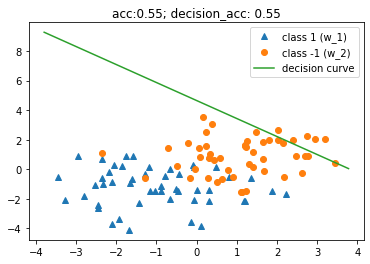

**********************************************seed 11***********************************************


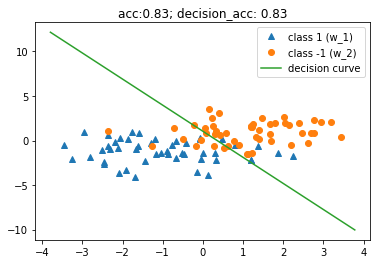

In [18]:
for i in [8, 11]:
    np.random.seed(i)
    print(f'seed {i}'.center(100, '*'))
    run_lms()

**总共100个样本，+1，-1各50个。注意到seed=8时，虽然决策面很离谱但是它分出了5个-1类，与所有（50个）+1类，所以就算这样，准确率仍然有55%**
**或者更加离谱的，一条将所有类别均划分为-1类或者+1类的分界线，其准确率也是有50%**

### 8.4.2 boosting

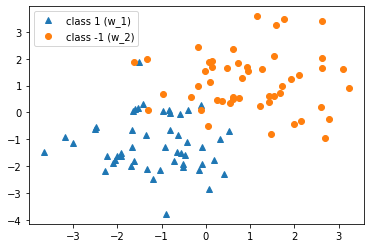

In [19]:
np.random.seed(13)

# 准备数据
n_samples = 100
centers = [[1, 1], [-1, -1]]
std = 1.2
prior = np.array([0.5, 0.5])
data, label = datasets.make_blobs(n_samples=n_samples, n_features=2, centers=centers, cluster_std=std)
label = 2 * label - 1

my_plot(data, label)

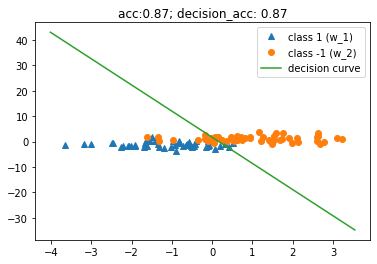

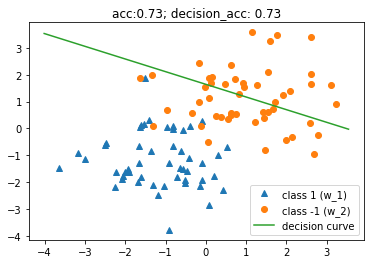

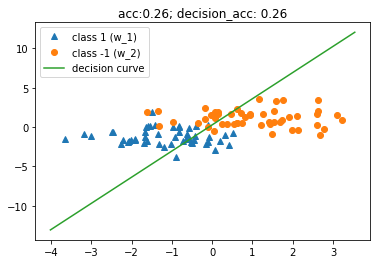

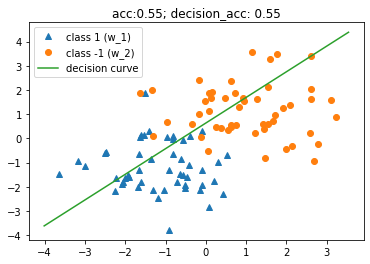

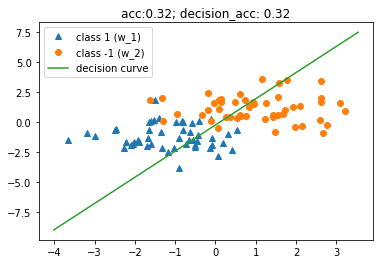

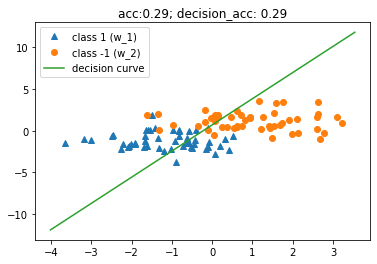

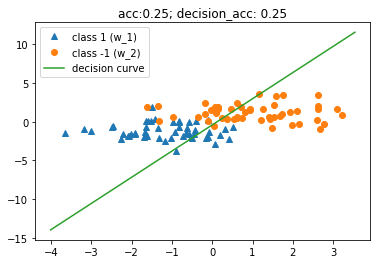

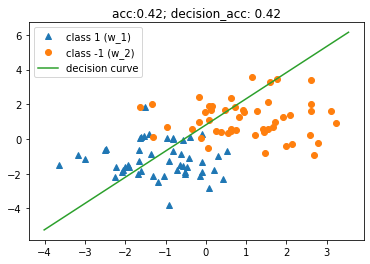

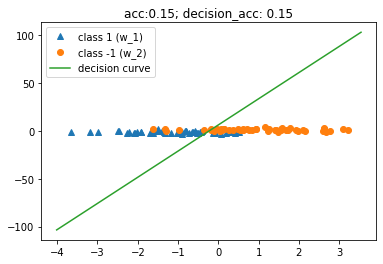

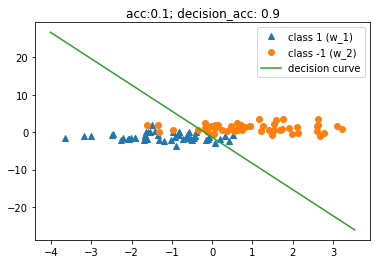

In [20]:
fisher_instance = mlc.Bossting(data, label, 10)
# fisher_instance.lms()
fisher_instance.start_boost()
_, boost_acc = fisher_instance.boost_predict()

In [21]:
print('all classifiers acc: ')
print(fisher_instance.classifiers['acc'])
print(f'boost acc: {boost_acc}')

all classifiers acc: 
[0.87, 0.73, 0.26, 0.55, 0.32, 0.29, 0.25, 0.42, 0.15, 0.1]
boost acc: 0.83


**其实这个算法的问题挺多的：**
**①简单分类器用的是加权最小误差平方判别，8.4.1用的是权值一样的最小误差判别，实际上就相当于没有加权。**
**在没有加权的算法之中，可以看出学习到的\alpha求出的k，都是小于0的，加权的为什么有的会学习到>0的？**
**②有些准确率特别低，比如0.25的那个，属于是正负类判反了，本来是决策面上面的是负类，下面的是正类，它给判反了，不过不影响Boosting，因为准确类小于0.5的，会给负权值，虽然类别判错了，但是负权值又给扭过来了**
**不过不知道为什么会判反**
**③最佳的简单分类器的准确类是1-0.1=0.9，为什么综合起来的只有0.83？**

# 11 非监督与聚类

In [1]:
import my_learning_class as mlc
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

In [2]:
n_samples = 7500
seed = 42
centers = [[100000, 100000], [-100000, -100000], [-100000, 100000]]
std = 40000
prior = np.array([0.5, 0.5])
data, label = datasets.make_blobs(n_samples=n_samples, n_features=3, centers=centers, cluster_std=std,
                                  random_state=seed)

In [3]:
def my_plot(data, label, label_cal):
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    plt.plot(data[np.where(label == 0), 0].T, data[np.where(label == 0), 1].T, 'ro', label='class 0', alpha=0.3)
    plt.plot(data[np.where(label == 1), 0].T, data[np.where(label == 1), 1].T, 'go', label='class 1', alpha=0.3)
    plt.plot(data[np.where(label == 2), 0].T, data[np.where(label == 2), 1].T, 'bo', label='class 2', alpha=0.3)
    plt.legend()
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()

    plt.subplot(1,2,2)
    plt.plot(data[np.where(label_cal == 0), 0].T, data[np.where(label_cal == 0), 1].T, 'ro', label='class 0', alpha=0.3)
    plt.plot(data[np.where(label_cal == 1), 0].T, data[np.where(label_cal == 1), 1].T, 'go', label='class 1', alpha=0.3)
    plt.plot(data[np.where(label_cal == 2), 0].T, data[np.where(label_cal == 2), 1].T, 'bo', label='class 2', alpha=0.3)
    plt.legend()
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.show()

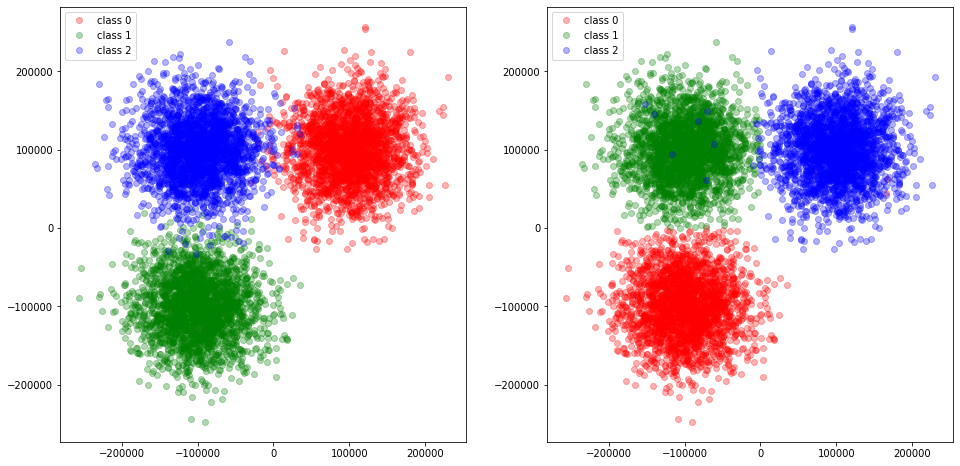

In [4]:
instance = mlc.Cluster(data, 'c_mean')
label_cal = instance.transform(c=3, N=instance.N*0.1)
my_plot(data, label, label_cal)

#11 非监督学习与聚类

## 11.1 基于模型的聚类方法

In [3]:
import matplotlib.pyplot as plt
import my_learning_class as mlc
import numpy as np
np.random.seed(42)

In [4]:
n = 3000
cov = np.array([[6, -3], [-3, 3.5]])
data0 = np.random.multivariate_normal([0, 0], [[2.5, 0.5], [0.5, 4]], size=n)
data1 = np.random.multivariate_normal([13, 27], [[5, 1], [1, 2.5]], size=n)
data2 = np.random.multivariate_normal([22, 13], [[5, 0], [0, 5]], size=n)

label = []
label.append(n * [0])
label.append(n * [1])
label.append(n * [2])

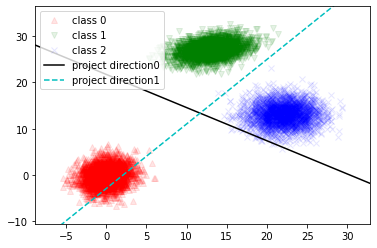

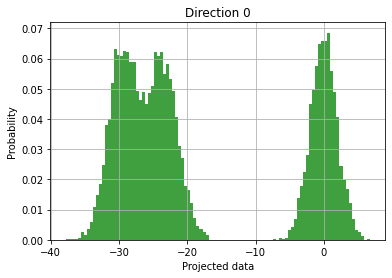

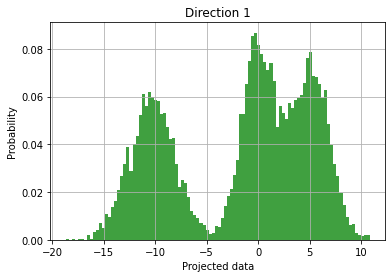

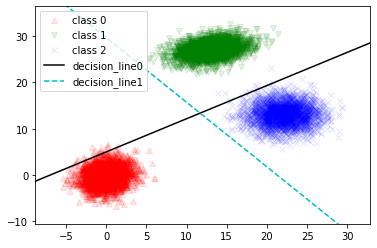

0

In [5]:
instance = mlc.UnimodalSeperate(data0, data1, data2, label)
instance.run()

**由于书上只讨论了方向，这里为了省事，令各直线过样本总均值点**